# Salary Prediction for Data Science Roles in the U.S.


### *Franco Pérez Rivera — Data Portfolio Project*




This report presents the final phase of a comprehensive data science project focused on predicting salaries for data-related roles across the United States.

Following a robust process of data cleaning, feature engineering, and exploratory analysis, this modeling stage aims to:

- Build accurate and interpretable machine learning models
- Compare linear and tree-based regression algorithms
- Evaluate model performance using cross-validation and multiple error metrics
- Diagnose overfitting and underfitting
- Apply regularization and hyperparameter tuning
- Explore ensemble methods to improve generalization

> **Target Variables**
> - `avg_salary` — used in tree-based models (original scale)
> - `BoxCox_Avg_Salary` — used in linear models (normalized)

> **Executive Summary**  
>  
> This notebook presents the final modeling phase of a salary prediction project for data-related jobs in the U.S. After extensive feature engineering and preprocessing, multiple linear and tree-based models were evaluated.  
>  
> The best-performing model was **LightGBM (Tuned)** with a Test R² of **0.745**, closely followed by a stacked ensemble (Test R² = 0.730). Regularization, pruning, and ensembling strategies were explored to improve generalization and interpretability.


## 1. Imports and Setup

We begin by importing the necessary libraries for modeling, evaluation, visualization, and interpretability.  
Warnings will be suppressed and plotting aesthetics will be standardized.

In [1]:
# Auto-reload for development (optional)
%load_ext autoreload
%autoreload 2


#Functions
import FunctionsModeling as f

# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Modeling - Linear and Tree-Based
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

# Advanced Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor

# Interpretability
import shap

# Stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

# Plot style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("muted")


## 2. Dataset Loading and Initial Inspection



We now load the preprocessed datasets used for modeling. Each dataset corresponds to a specific modeling approach (exploratory analysis, linear modeling, and tree-based modeling).

The objective of this step is to confirm dataset structure, detect potential issues such as missing values or duplicates, and ensure consistency across modeling inputs.

Key checks performed:

- Dataset dimensions and shape
- Presence of missing values
- Duplicate rows
- Data types and variable distribution

After loading, the `BoxCox_Avg_Salary` column is recalculated using the same lambda value obtained during the transformation of the original `avg_salary` variable, ensuring consistency across all subsets.


In [2]:
import pandas as pd

# Lista de archivos a cargar desde la carpeta Data
file_names_model = [
    "../Data/df_analysis_model.csv",
    "../Data/df_modeling_tree_model.csv",
    "../Data/df_modeling_linear_model.csv"
]

# Nombres amigables para referencia
df_names = ["df_analysis", "df_modeling_tree", "df_modeling_linear"]

# Cargar archivos y analizarlos
loaded_dfs = []

for name, path in zip(df_names, file_names_model):
    df = pd.read_csv(path)
    loaded_dfs.append(df)

    print(f"📂 {name} — Shape: {df.shape}")
    print("🧼 Missing values:")
    print(df.isna().sum().sort_values(ascending=False).head())

    print("🧾 Duplicate rows:", df.duplicated().sum())
    print("📊 Data types:")
    print(df.dtypes.value_counts(), "\n" + "-"*50 + "\n")

# Reasignar a variables si lo necesitás después
df_analysis, df_modeling_tree, df_modeling_linear = loaded_dfs
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]


📂 df_analysis — Shape: (465, 19)
🧼 Missing values:
Company_Size              6
Rating                    0
BoxCox_Avg_Salary         0
Python_Tools_Knowledge    0
Region                    0
dtype: int64
🧾 Duplicate rows: 1
📊 Data types:
object     9
int64      6
float64    4
Name: count, dtype: int64 
--------------------------------------------------

📂 df_modeling_tree — Shape: (737, 19)
🧼 Missing values:
Company_Size              10
Rating                     0
BoxCox_Avg_Salary          0
Python_Tools_Knowledge     0
Region                     0
dtype: int64
🧾 Duplicate rows: 273
📊 Data types:
object     9
int64      6
float64    4
Name: count, dtype: int64 
--------------------------------------------------

📂 df_modeling_linear — Shape: (465, 20)
🧼 Missing values:
Company_Size              6
Rating                    0
Ownership_Type            0
Python_Tools_Knowledge    0
Region                    0
dtype: int64
🧾 Duplicate rows: 1
📊 Data types:
object     9
int64      7
float

In [3]:
from sklearn.preprocessing import PowerTransformer

# Refit PowerTransformer on the full original 'avg_salary' distribution
boxcox = PowerTransformer(method="box-cox")
boxcox.fit(df_modeling_tree[["avg_salary"]])  # Use full data for consistency
boxcox_lambda = boxcox.lambdas_[0]
print(f"✅ Lambda used in Box-Cox transformation: {boxcox_lambda:.4f}")

# Apply the transformation to all DataFrames
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]
for i in range(len(all_dfs)):
    df = all_dfs[i]
    df["BoxCox_Avg_Salary"] = boxcox.transform(df[["avg_salary"]])
    all_dfs[i] = df

# Reassign updated versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs


✅ Lambda used in Box-Cox transformation: 0.3794


## 3. Feature Engineering: Interaction Terms and Non-Linear Transformations


To enhance the predictive power of the models, we introduce new features that capture potential non-linear patterns and domain-specific interactions.

These engineered features aim to represent relationships that are not easily captured by individual variables:

- **`rating_squared`**: captures potential non-linear effects of the company's Glassdoor rating.
- **`tool_experience_match`**: interaction between technical tool knowledge and professional experience level.
- **`sector_region_cat`**: combination of industry sector and geographic region to capture regional job market variations.
- **`size_ownership_cat`**: joint category of company size and ownership type, which may influence compensation structure.

All newly created features are added to each modeling dataset and encoded as categorical variables when appropriate.

In [4]:
# Apply to all DataFrames
all_dfs = [df_analysis, df_modeling_tree, df_modeling_linear]
for i in range(len(all_dfs)):
    df = all_dfs[i]

    # 1. Non-linear transformation of Rating
    df["rating_squared"] = df["Rating"] ** 2

    # 2. Tool × Experience interaction
    df["tool_experience_match"] = np.where(
        (df["Python_Knowledge"] + df["Python_Tools_Knowledge"] >= 1) &
        (~df["Experience_Level"].isin(["Entry Level", "Unknown"])),
        1, 0
    )

    # 3. Sector × Region interaction
    df["sector_region_cat"] = df["Sector"].astype(str) + " | " + df["Region"].astype(str)

    # 4. Size × Ownership interaction
    df["size_ownership_cat"] = df["Company_Size"].astype(str) + " | " + df["Ownership_Type"].astype(str)

    # Convert to category
    df["sector_region_cat"] = df["sector_region_cat"].astype("category")
    df["size_ownership_cat"] = df["size_ownership_cat"].astype("category")

    all_dfs[i] = df

# Reassign updated versions
df_analysis, df_modeling_tree, df_modeling_linear = all_dfs

# Preview the result in df_analysis
print("✅ New interaction features created:")
print(df_analysis[["rating_squared", "tool_experience_match", "sector_region_cat", "size_ownership_cat"]].head(3))


✅ New interaction features created:
   rating_squared  tool_experience_match  \
0           14.44                      1   
1           11.56                      1   
2           23.04                      1   

                             sector_region_cat  \
0              Industry & Finance | West Other   
1              Health, Education & Retail | MD   
2  Professional & Other Services | South Other   

                    size_ownership_cat  
0   Medium Company | Company - Private  
1  Corporation / Multinational | Other  
2   Medium Company | Company - Private  


## 4. Multicollinearity Check


Before fitting predictive models, we assess multicollinearity to ensure model stability and interpretability.

For **numerical features**, we apply two techniques:
- **Correlation matrix**: to visualize linear relationships between variables.
- **Variance Inflation Factor (VIF)**: to quantify the level of multicollinearity, identifying redundant predictors.

To prevent issues in linear models, highly collinear variables such as `Rating` and its squared version (`rating_squared`) are handled accordingly. Only one of them is retained in models where multicollinearity is a concern.

For **categorical features**, we compute **Cramér’s V**, a measure of association based on the chi-squared statistic. This identifies strong dependencies between categorical variables.

Redundant categorical features are further evaluated using **ANOVA and Eta Squared** to determine their relative predictive power. Features with high association but low explanatory strength are removed to reduce redundancy and noise.

### a. Numerical

To ensure model stability and interpretability, we inspect potential multicollinearity among numerical features.  
This includes computing the correlation matrix and calculating the Variance Inflation Factor (VIF).


In [5]:
# Step 1: Identify target columns
target_cols = ["avg_salary", "BoxCox_Avg_Salary"]

# Step 2: Identify binary columns (2 unique values)
binary_cols = [
    col for col in df_modeling_linear.columns
    if df_modeling_linear[col].nunique(dropna=False) == 2 and col not in target_cols and "boxcox" not in col.lower()
]

# Step 3: Identify categorical columns (non-binary, low cardinality)
cat_cols = [
    col for col in df_modeling_linear.select_dtypes(include=["object", "category"]).columns
    if col not in binary_cols and col not in target_cols and "boxcox_lambda" not in col.lower()
]


# Step 4: Identify numeric columns (excluding target and already captured ones)
numeric_cols = [
    col for col in df_modeling_linear.select_dtypes(include=["int64", "float64"]).columns
    if col not in target_cols + binary_cols
]

# Step 5: Move columns from numeric to categorical if they have too few unique values
for col in numeric_cols.copy():
    if df_modeling_linear[col].nunique() < 10:
        numeric_cols.remove(col)
        cat_cols.append(col)

# Step 6: Identify other columns not captured
other_cols = [
    col for col in df_modeling_linear.columns
    if col not in target_cols + binary_cols + cat_cols + numeric_cols
]

# Output results
binary_cols, cat_cols, numeric_cols, other_cols

cat_cols = [col for col in cat_cols if col != "boxcox_lambda"]
if "boxcox_lambda" in cat_cols:
    cat_cols.remove("boxcox_lambda")

cols = binary_cols + cat_cols

# ✅ Summary
print("Numeric columns:", len(numeric_cols))
print("Binary columns:", len(binary_cols))
print("Categorical columns:", len(cat_cols))
print("Other columns:", len(other_cols))

print("Cols",len(cols))


Numeric columns: 3
Binary columns: 6
Categorical columns: 12
Other columns: 0
Cols 18


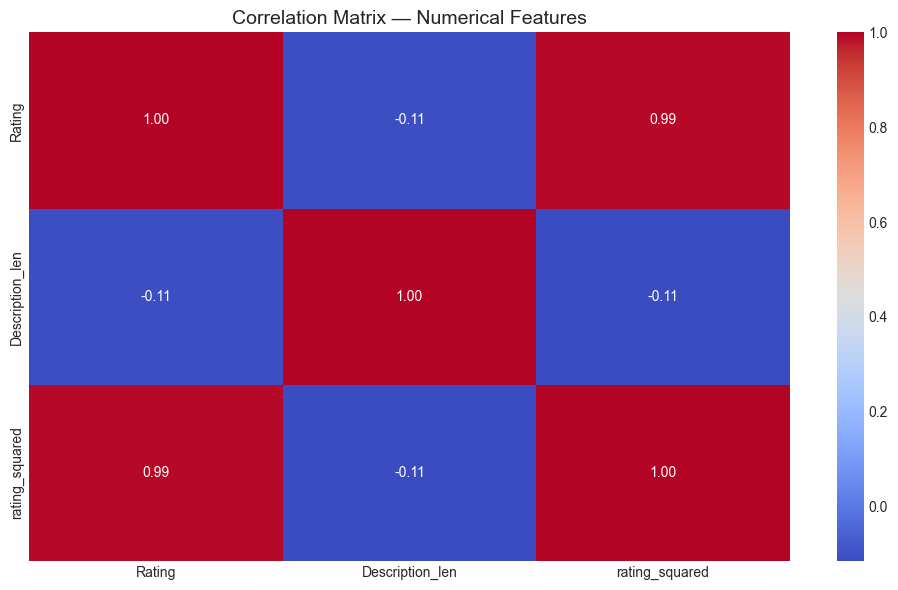

,Feature,VIF
2,rating_squared,80.310604
0,Rating,80.169631
1,Description_len,1.017513


In [6]:
# 1. Correlation matrix
plt.figure(figsize=(10, 6))
corr = df_modeling_linear[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix — Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

# 2. VIF calculation
# Standardize features for VIF (not mandatory but improves stability)
from sklearn.preprocessing import StandardScaler

X_vif = df_modeling_linear[numeric_cols].dropna()
X_scaled = StandardScaler().fit_transform(X_vif)

vif_df = pd.DataFrame()
vif_df["Feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

# Sort and display
vif_df.sort_values("VIF", ascending=False)

> ℹ️ **Note on `Rating` vs `rating_squared`:**

Including both `Rating` and `rating_squared` introduces perfect multicollinearity, as one is a non-linear transformation of the other.  
While `rating_squared` may help capture non-linear effects in salary prediction, especially for linear models, using both features in the same model is not recommended.

**Modeling strategy:**
- For **linear models**, we will keep only `rating_squared` to allow for quadratic relationships while avoiding multicollinearity.
- For **tree-based models**, we can retain both features, as they are not affected by collinearity.


In [7]:
df_modeling_linear.drop(columns=["Rating"], inplace=True)

### b. Categorical Multicollinearity — Cramér’s V



While numerical features can be checked for multicollinearity using correlation matrices and VIF, categorical variables require a different approach.  
We use **Cramér’s V statistic**, which measures association strength between pairs of categorical variables based on the chi-squared test. (function `cramers_v_matrix`)

We apply it to all categorical features with a limited number of unique values (≤ 20) to avoid computational overload or sparse matrices.


Analyzing 16 categorical columns: ['Python_Knowledge', 'Tableau_Knowledge', 'R_Knowledge', 'Python_Tools_Knowledge', 'Cloud_or_BigData_Knowledge', 'tool_experience_match', 'Ownership_Type', 'Sector', 'Job_Function', 'Experience_Level', 'Age_Group', 'Company_Size', 'Industry_Group', 'Revenue_Group', 'Region', 'weight']


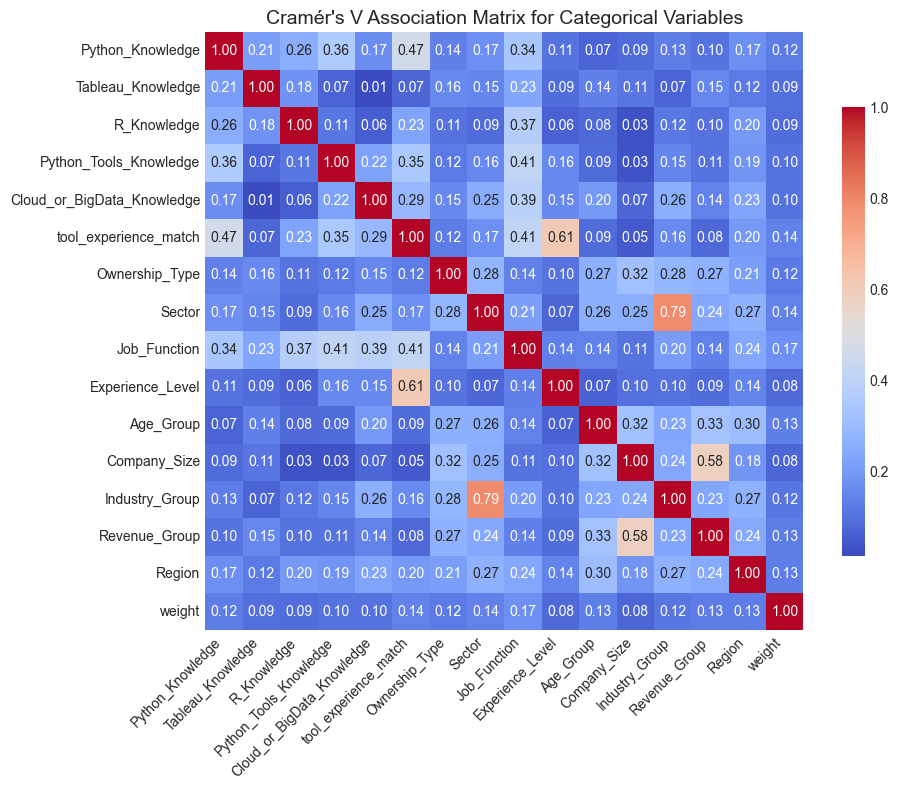


Highly correlated categorical pairs (Cramér's V > 0.6):
('Sector', 'Industry_Group', 0.786)
('tool_experience_match', 'Experience_Level', 0.614)
('Company_Size', 'Revenue_Group', 0.581)
('Python_Knowledge', 'tool_experience_match', 0.465)
('tool_experience_match', 'Job_Function', 0.415)
('Python_Tools_Knowledge', 'Job_Function', 0.408)
('Cloud_or_BigData_Knowledge', 'Job_Function', 0.385)
('R_Knowledge', 'Job_Function', 0.373)
('Python_Knowledge', 'Python_Tools_Knowledge', 0.361)


In [8]:
cramer_matrix, high_corr_pairs = f.cramers_v_matrix(df_modeling_linear, cols, threshold=0.35)

print("\nHighly correlated categorical pairs (Cramér's V > 0.6):")
for pair in high_corr_pairs:
    print(pair)


#### 1. Redundant Categorical Variables — Comparison via ANOVA & Eta Squared



Some categorical variables are strongly associated with each other, as shown by the Cramér’s V matrix.  
To avoid redundancy and multicollinearity in the encoded dataset, we compare overlapping variables based on their **predictive power** over the target.

We use a custom function `compare_categorical_predictors_for_model()` to:
- Run an ANOVA test between each category and the salary
- Compute the **explained variance (Eta Squared / R²)**

For each highly associated pair (Cramér’s V > 0.35), we retain the variable with **greater explanatory power**.

In [9]:
to_remove, comparison_summary = f.compare_categorical_predictors_in_pairs(
    df_modeling_linear,
    high_corr_pairs,
    target="BoxCox_Avg_Salary"
)

print("\n🚫 Suggested columns to drop due to collinearity and low explanatory power:")
print(to_remove)

# Ensure only existing columns are dropped
existing_columns_to_remove = [col for col in to_remove if col in df_modeling_linear.columns]
df_modeling_linear = df_modeling_linear.drop(columns=existing_columns_to_remove)



🔎 Comparing: Sector vs Industry_Group
         Variable  ANOVA p-value  Explained Variance (R²)
1  Industry_Group         0.0001                    0.052
0          Sector         0.0025                    0.035

🔎 Comparing: tool_experience_match vs Experience_Level
                Variable  ANOVA p-value  Explained Variance (R²)
0  tool_experience_match            0.0                    0.059
1       Experience_Level            0.0                    0.055

🔎 Comparing: Company_Size vs Revenue_Group
        Variable  ANOVA p-value  Explained Variance (R²)
1  Revenue_Group         0.0005                    0.042
0   Company_Size         0.0119                    0.024

🔎 Comparing: Python_Knowledge vs tool_experience_match
                Variable  ANOVA p-value  Explained Variance (R²)
1  tool_experience_match          0.000                    0.059
0       Python_Knowledge          0.001                    0.023

🔎 Comparing: tool_experience_match vs Job_Function
                Va

## 5. Preparation for Modeling



With the final set of features defined, we prepare the data for training and evaluation.

Two modeling pipelines are developed in parallel:

- **Linear models** use the normalized target variable `BoxCox_Avg_Salary` and require:
  - Standardization of numerical features
  - One-hot encoding of categorical variables
  - Preservation of binary variables as-is

- **Tree-based models** use the original target `avg_salary` and do not require scaling. However, categorical variables are one-hot encoded to ensure compatibility across implementations.

A stratified train-test split (75%/25%) is applied to both datasets using a fixed random seed to ensure reproducibility.

These prepared datasets are used in all subsequent modeling steps, including baseline comparisons, regularization, hyperparameter tuning, and ensemble methods.


### a. Train/Test Split & Target Selection


We now split the dataset into training and test sets.  
The choice of target variable depends on the type of model to be trained:

- **Linear models**: require normally distributed targets → we use `BoxCox_Avg_Salary`
- **Tree-based models**: are distribution-agnostic → we use `avg_salary` directly

The features (`X`) include all remaining columns except the target(s).

In [10]:
from sklearn.model_selection import train_test_split

# Features and target for tree-based models
X_tree = df_modeling_tree.drop(columns=["avg_salary", "BoxCox_Avg_Salary", "boxcox_lambda", "weight"], errors="ignore")
y_tree = df_modeling_tree["avg_salary"]

# Features and target for linear models
X_linear = df_modeling_linear.drop(columns=["avg_salary", "BoxCox_Avg_Salary", "boxcox_lambda"], errors="ignore")
y_linear = df_modeling_linear["BoxCox_Avg_Salary"]

# Extract weight for linear models if available
weight = df_modeling_linear["weight"] if "weight" in df_modeling_linear.columns else None


# Train/Test split (25% test, same random seed)
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(
    X_tree, y_tree, test_size=0.25, random_state=42
)

from sklearn.model_selection import train_test_split

# Dividí también el weight
X_linear_train, X_linear_test, y_linear_train, y_linear_test, weight_train, weight_test = train_test_split(
    X_linear,
    y_linear,
    weight,
    test_size=0.25,
    random_state=42
)


# Summary
print("✅ Train/test split completed:")
print(f"X_tree_train shape: {X_tree_train.shape}")
print(f"X_tree_test shape:  {X_tree_test.shape}")
print(f"X_linear_train shape: {X_linear_train.shape}")
print(f"X_linear_test shape:  {X_linear_test.shape}")


✅ Train/test split completed:
X_tree_train shape: (552, 20)
X_tree_test shape:  (185, 20)
X_linear_train shape: (348, 12)
X_linear_test shape:  (117, 12)


### b. Preprocessing Pipeline for Linear Models

To prepare the data for linear models, we build a preprocessing pipeline that includes:

- **Standardization** for numerical features
- **One-hot encoding** for categorical features
- Binary variables are left unchanged

We use `ColumnTransformer` to apply each transformation only to the appropriate feature set.

In [11]:
# Identify variable types in X_linear
binary_vars = [col for col in X_linear_train.columns if X_linear_train[col].nunique() == 2 and X_linear_train[col].dtype in ['int64', 'int32']]
numeric_vars = X_linear_train.select_dtypes(include=['int64', 'float64']).columns.difference(binary_vars).tolist()
categorical_vars = X_linear_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Confirm selections
print(f"Numerical vars: {numeric_vars}")
print(f"Categorical vars: {categorical_vars}")
print(f"Binary vars: {binary_vars}")

# Column transformer: numeric → scale, categorical → one-hot
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_vars),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_vars)
    ],
    remainder='passthrough'  # Leave binary variables untouched
)

# Full pipeline: preprocessing only (model will be added later)
linear_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor)
])

# Fit and transform training data
X_linear_train_prepared = linear_pipeline.fit_transform(X_linear_train)
X_linear_test_prepared = linear_pipeline.transform(X_linear_test)

print("Linear preprocessing pipeline applied successfully.")
print(f"Transformed X_train shape: {X_linear_train_prepared.shape}")

Numerical vars: ['Description_len', 'rating_squared', 'weight']
Categorical vars: ['Ownership_Type', 'Job_Function', 'Age_Group', 'Industry_Group', 'Revenue_Group', 'Region', 'sector_region_cat', 'size_ownership_cat']
Binary vars: ['Tableau_Knowledge']
Linear preprocessing pipeline applied successfully.
Transformed X_train shape: (348, 103)


### c. Preparing Data for Tree-Based Models


Tree-based models (Random Forest, XGBoost, LightGBM) do not require feature scaling or one-hot encoding.  
They handle:
- Numerical features directly
- Binary features natively
- Categorical features once they are properly encoded

To prepare the data, we simply apply `OneHotEncoding` to categorical variables.

In [12]:
# Separate types
categorical_tree_vars = X_tree_train.select_dtypes(include=['object', 'category']).columns.tolist()
other_tree_vars = X_tree_train.drop(columns=categorical_tree_vars).columns.tolist()

# Encode categorical
encoder_tree = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_train = pd.DataFrame(
    encoder_tree.fit_transform(X_tree_train[categorical_tree_vars]),
    columns=encoder_tree.get_feature_names_out(categorical_tree_vars),
    index=X_tree_train.index
)

encoded_test = pd.DataFrame(
    encoder_tree.transform(X_tree_test[categorical_tree_vars]),
    columns=encoder_tree.get_feature_names_out(categorical_tree_vars),
    index=X_tree_test.index
)

# Combine encoded + other columns
X_tree_train_final = pd.concat([X_tree_train[other_tree_vars].reset_index(drop=True), encoded_train.reset_index(drop=True)], axis=1)
X_tree_test_final = pd.concat([X_tree_test[other_tree_vars].reset_index(drop=True), encoded_test.reset_index(drop=True)], axis=1)

# Confirm shape
print("✅ Tree-based features prepared successfully.")
print(f"X_tree_train_final shape: {X_tree_train_final.shape}")
print(f"X_tree_test_final shape: {X_tree_test_final.shape}")
    

✅ Tree-based features prepared successfully.
X_tree_train_final shape: (552, 123)
X_tree_test_final shape: (185, 123)


## 6. Models

This section develops and evaluates multiple regression models, including linear, tree-based, and ensemble approaches. Performance is assessed using cross-validation, multiple error metrics, and residual diagnostics.


### a. Baseline Modeling and Comparison


We begin the modeling phase by fitting two baseline regressors:

- **Linear Regression** on the Box-Cox transformed target (`BoxCox_Avg_Salary`)
- **Random Forest Regressor** on the original target (`avg_salary`)

This initial comparison allows us to:

- Evaluate the general performance of both model families
- Identify issues such as bias, variance, or poor fit
- Establish reference metrics for more advanced models

Performance is assessed using:

- **R² (coefficient of determination)** for explanatory power
- **MAE (mean absolute error)** for interpretability
- **RMSE (root mean squared error)** for penalizing large errors

Visual diagnostics such as residual plots and prediction vs. actual graphs are used to analyze patterns in the model errors and guide further model selection and refinement.

In [13]:
# 1. Linear Regression (BoxCox target)
lr_model = LinearRegression()
lr_model.fit(X_linear_train_prepared, y_linear_train, sample_weight=weight_train)

y_lr_train_pred = lr_model.predict(X_linear_train_prepared)
y_lr_test_pred = lr_model.predict(X_linear_test_prepared)

lr_results = f.evaluate_model(
    y_linear_train, y_lr_train_pred,
    y_linear_test, y_lr_test_pred,
    model_name="Linear Regression (BoxCox)",
    boxcox_transformer=boxcox,
    transform_back=True
)

# 2. Random Forest (original salary)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_tree_train_final, y_tree_train)
y_rf_train_pred = rf_model.predict(X_tree_train_final)
y_rf_test_pred = rf_model.predict(X_tree_test_final)

rf_base_results = f.evaluate_model(
    y_tree_train, y_rf_train_pred,
    y_tree_test, y_rf_test_pred,
    model_name="Random Forest (Base)"
)



In [14]:
lr_results

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
0,Linear Regression (BoxCox),11.95,16.10,21.06,26.07,0.295,-0.287


In [15]:
rf_base_results

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
0,Random Forest (Base),5.17,12.42,8.04,19.18,0.951,0.685


#### 1. Residual & Prediction Visualization


We now visualize the model predictions versus actual values to check:

- Distribution of residuals
- Spread of prediction vs true values
- Potential bias patterns

In [16]:
# Helper function
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred

    plt.figure(figsize=(14, 4))

    # Residuals distribution
    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f"{model_name} — Residuals Distribution")
    plt.xlabel("Residuals")

    # Predicted vs Actual
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(f"{model_name} — Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

    plt.tight_layout()
    plt.show()

# Apply to both models
#plot_residuals(y_linear_test, y_linear_pred, "Linear Regression (BoxCox)")
#plot_residuals(y_tree_test, y_tree_pred, "Random Forest")

In [17]:
print("BoxCox_Avg_Salary range:")
print("Min:", y_linear_train.min())
print("Max:", y_linear_train.max())


BoxCox_Avg_Salary range:
Min: -3.6252214749938765
Max: 2.950430498988416


In [18]:
# Revisar si está en X_linear
print("'rating_squared' in raw X_linear_train:", 'rating_squared' in X_linear_train.columns)

# Revisar su valor antes de escalar
print("Original rating_squared stats:")
#print(X_linear_train['rating_squared'].describe())


'rating_squared' in raw X_linear_train: True
Original rating_squared stats:


In [19]:
print("Transformed X (linear) max and min values:")
print("Max:", X_linear_train_prepared.max())
print("Min:", X_linear_train_prepared.min())


Transformed X (linear) max and min values:
Max: 4.110267304053926
Min: -2.5615803064097733


In [20]:
# Revisar valores extremos por columna
import pandas as pd

# Convert numpy array back to DataFrame (temporal, para investigar)
X_linear_df_debug = pd.DataFrame(
    X_linear_train_prepared,
    columns=linear_pipeline.named_steps['preprocessing'].get_feature_names_out()
)

# Ver extremos
print("Top 5 features with max absolute values:")
print(X_linear_df_debug.abs().max().sort_values(ascending=False).head())


Top 5 features with max absolute values:
num__Description_len                                          4.110267
num__weight                                                   3.245447
num__rating_squared                                           2.660086
cat__size_ownership_cat_nan | Other                           1.000000
cat__sector_region_cat_Tech / Innovation | Northeast Other    1.000000
dtype: float64


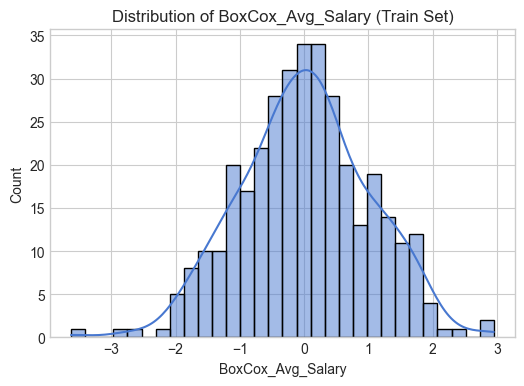

Min: -3.6252214749938765
Max: 2.950430498988416


In [21]:
plt.figure(figsize=(6, 4))
sns.histplot(y_linear_train, kde=True, bins=30)
plt.title("Distribution of BoxCox_Avg_Salary (Train Set)")
plt.xlabel("BoxCox_Avg_Salary")
plt.show()

print("Min:", y_linear_train.min())
print("Max:", y_linear_train.max())


In [22]:
print("Shapes:")
print("X_linear_train_prepared:", X_linear_train_prepared.shape)
print("y_linear_train:", y_linear_train.shape)

# Verificamos que los índices coincidan (por si hubo un reset_index mal hecho)
print("Index match:", y_linear_train.index.equals(X_linear_train.index))


Shapes:
X_linear_train_prepared: (348, 103)
y_linear_train: (348,)
Index match: True


In [23]:
from sklearn.feature_selection import VarianceThreshold

# Revisar si hay columnas con varianza muy baja en X_linear_train_prepared
selector = VarianceThreshold(threshold=1e-6)
selector.fit(X_linear_train_prepared)

low_var_features = ~selector.get_support()
low_var_count = sum(low_var_features)

print(f"Number of near-constant features: {low_var_count}")


Number of near-constant features: 0


### b. Regularized Linear Models (Ridge & Lasso)

To address overfitting and improve generalization in linear models, we apply L2 (Ridge) and L1 (Lasso) regularization.

- **Ridge** stabilizes coefficients in the presence of multicollinearity.
- **Lasso** can also perform feature selection by shrinking some coefficients to zero.

> Lasso achieved slightly better generalization (Test R² = 0.42) than Ridge, though both were outperformed by tree-based models.



In [24]:
from sklearn.linear_model import Ridge, Lasso

# Ridge
# Entrenamiento Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_linear_train_prepared, y_linear_train, sample_weight=weight_train)
y_ridge_train_pred = ridge.predict(X_linear_train_prepared)
y_ridge_test_pred = ridge.predict(X_linear_test_prepared)

# Entrenamiento Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_linear_train_prepared, y_linear_train, sample_weight=weight_train)
y_lasso_train_pred = lasso.predict(X_linear_train_prepared)
y_lasso_test_pred = lasso.predict(X_linear_test_prepared)



In [25]:
ridge_results = f.evaluate_model(
    y_linear_train, y_ridge_train_pred,
    y_linear_test, y_ridge_test_pred,
    model_name="Ridge Regression",
    #boxcox_transformer=boxcox,  # tu PowerTransformer
    #transform_back=True
)
ridge_results

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
0,Ridge Regression,0.52,0.63,0.69,0.77,0.527,0.291


In [26]:

lasso_results = f.evaluate_model(y_linear_train, y_lasso_train_pred, y_linear_test, y_lasso_test_pred,
                 model_name="Lasso Regression"
)
                 #, 
                 #boxcox_transformer=boxcox,  # tu PowerTransformer
                 #transform_back=True)

lasso_results

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
0,Lasso Regression,0.57,0.57,0.74,0.70,0.452,0.424


### c. Learning Curves — Bias vs. Variance Diagnosis



Learning curves for Ridge and Random Forest help visualize model learning behavior and diagnose underfitting or overfitting.

>- **Ridge** shows signs of underfitting, with high training and test errors.
>- **Random Forest** shows better generalization and benefits from more data.

>These insights guide further tuning and feature adjustments.


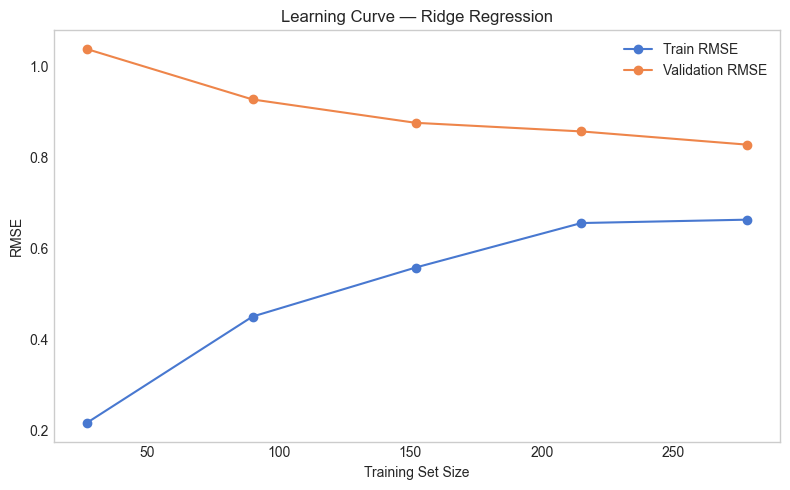

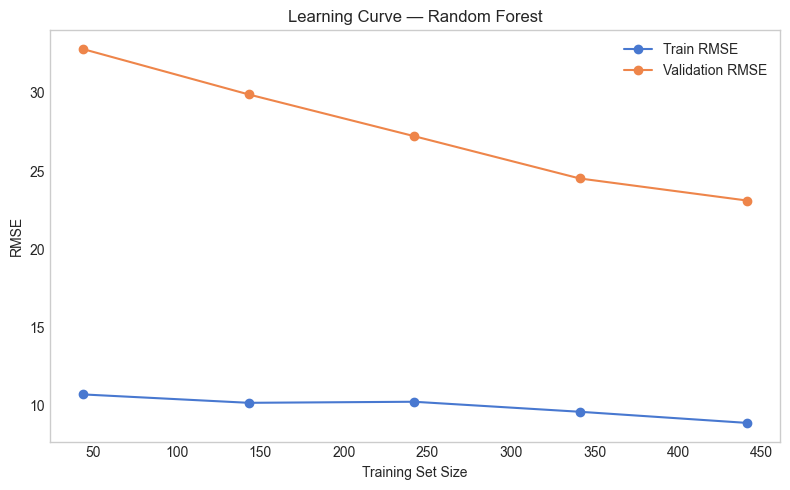

In [27]:
# Ridge curve (on BoxCox target)
f.plot_learning_curve(Ridge(alpha=1.0), X_linear_train_prepared, y_linear_train, 
                    "Learning Curve — Ridge Regression")

# Random Forest curve (on original target)
f.plot_learning_curve(RandomForestRegressor(random_state=42), X_tree_train_final, y_tree_train, 
                    "Learning Curve — Random Forest")

### d. Random Forest Optimization

After evaluating the baseline Random Forest model, we perform hyperparameter tuning to improve its generalization and reduce potential overfitting.

Key parameters tuned include:

- `max_depth`: limits the maximum depth of each tree
- `min_samples_leaf`: defines the minimum number of samples required in a leaf node
- `max_features`: controls the number of features considered when splitting

We use **GridSearchCV** with 5-fold cross-validation and root mean squared error (RMSE) as the scoring metric.

The optimized model is retrained on the full training set, and its performance is compared against the baseline using standard evaluation metrics.

Learning curves are also generated for the tuned model to visualize improvements in training dynamics and model stability.


>The tuned model (via GridSearchCV) improved performance modestly over the baseline (Test R² from 0.706 → 0.688), confirming strong initial performance.


In [28]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2', 0.8]
}

# Instantiate model
rf = RandomForestRegressor(random_state=42)

# Grid Search with 5-fold CV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit to training data
grid_search.fit(X_tree_train_final, y_tree_train)

# Best model
best_rf = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1}


In [29]:
# Predictions
y_rf_opt_train_pred = best_rf.predict(X_tree_train_final)
y_rf_opt_test_pred = best_rf.predict(X_tree_test_final)

# Evaluate
rf_opt_results = f.evaluate_model(
    y_tree_train, y_rf_opt_train_pred,
    y_tree_test, y_rf_opt_test_pred,
    model_name="Random Forest (Tuned)"
)

rf_opt_results

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
0,Random Forest (Tuned),5.20,12.87,7.87,19.45,0.953,0.676


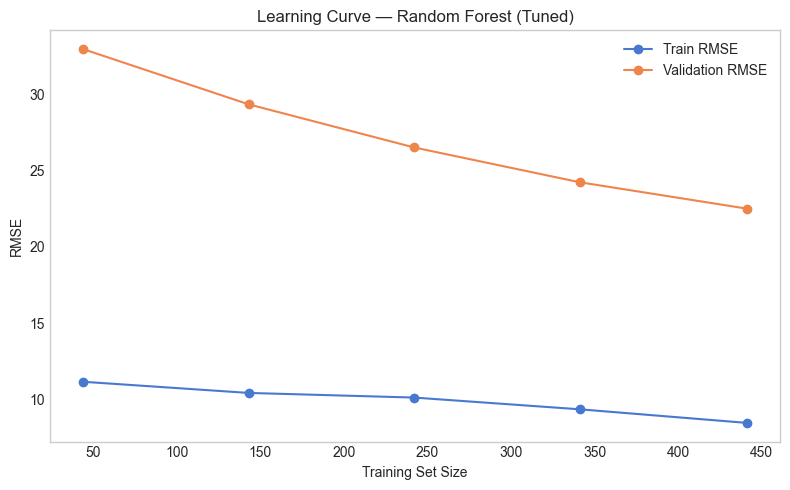

In [30]:
# Learning curve using the best estimator found in GridSearchCV
f.plot_learning_curve(
    best_rf,
    X_tree_train_final,
    y_tree_train,
    "Learning Curve — Random Forest (Tuned)"
)

### e. Feature Importance — Tuned Random Forest




Feature importance analysis from the optimized Random Forest highlights the most influential predictors of salary. These insights guide feature pruning and enhance interpretability.

> Feature importance revealed a long tail of low-contributing predictors, justifying the next pruning step.


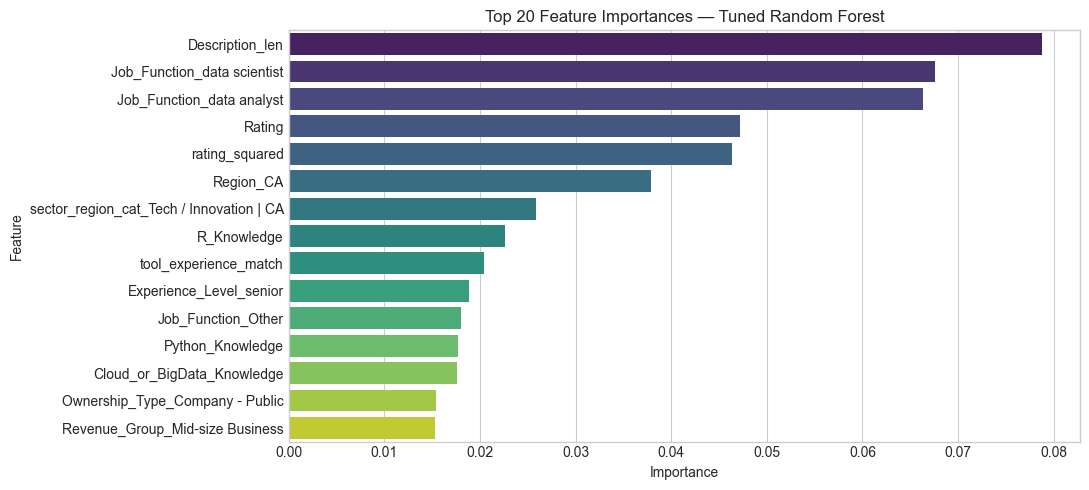

In [31]:
# Obtener importancias y nombres
importances = best_rf.feature_importances_
feature_names = X_tree_train_final.columns

# Crear DataFrame ordenado
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualizar top N
plt.figure(figsize=(11, 5))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Feature Importances — Tuned Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### f. Feature Pruning and Model Retraining




Features with very low importance (< 0.005) are removed to simplify the model. 

> Pruning 61 low-importance features resulted in a simpler model with nearly identical performance (Test R² = 0.684).


In [32]:
# Threshold for removal
threshold = 0.005

# Detect features below threshold
low_importance_features = feat_imp_df[feat_imp_df['Importance'] < threshold]['Feature'].tolist()
print(f"Dropping {len(low_importance_features)} features with importance < {threshold}")

# Drop from training and test sets
X_tree_train_reduced = X_tree_train_final.drop(columns=low_importance_features)
X_tree_test_reduced = X_tree_test_final.drop(columns=low_importance_features)


Dropping 61 features with importance < 0.005


We now retrain the tuned Random Forest using only the most important features.  
This allows us to test whether removing low-importance variables improves generalization.

In [33]:
# Re-train the best model with reduced features
best_rf_reduced = RandomForestRegressor(
    **grid_search.best_params_,
    random_state=42
)

best_rf_reduced.fit(X_tree_train_reduced, y_tree_train)

# Predictions
y_rf_red_train_pred = best_rf_reduced.predict(X_tree_train_reduced)
y_rf_red_test_pred = best_rf_reduced.predict(X_tree_test_reduced)

# Evaluate
rf_red_results = f.evaluate_model(
    y_tree_train, y_rf_red_train_pred,
    y_tree_test, y_rf_red_test_pred,
    model_name="Random Forest (Reduced Features)"
)

rf_red_results

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
0,Random Forest (Reduced Features),5.00,12.97,7.72,19.69,0.955,0.667


### g. XGBoost Modeling and Tuning




XGBoost is trained and tuned using RandomizedSearchCV. 

> The tuned model achieved strong performance (Test R² = 0.691), positioning it just behind Random Forest and LightGBM in terms of generalization. It was later used in stacking ensembles.


In [34]:
# Instanciar modelo (config base inicial)
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entrenamiento
xgb_model.fit(X_tree_train_reduced, y_tree_train)

# Predicciones
y_xgb_train_pred = xgb_model.predict(X_tree_train_reduced)
y_xgb_test_pred = xgb_model.predict(X_tree_test_reduced)

# Evaluación
f.evaluate_model(
    y_tree_train, y_xgb_train_pred,
    y_tree_test, y_xgb_test_pred,
    model_name="XGBoost"
)

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
0,XGBoost,2.10,11.84,3.18,19.26,0.992,0.682




#### 1. Hyperparameter Tuning — XGBoost with RandomizedSearchCV




We now perform a randomized search to optimize XGBoost’s hyperparameters and reduce overfitting.


In [35]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Rango de hiperparámetros
param_dist = {
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

xgb_base = XGBRegressor(random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_tree_train_reduced, y_tree_train)

# Mejor modelo
best_xgb = xgb_search.best_estimator_
print("Best XGBoost params:", xgb_search.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best XGBoost params: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}


In [36]:
# Predicciones
y_xgb_opt_train_pred = best_xgb.predict(X_tree_train_reduced)
y_xgb_opt_test_pred = best_xgb.predict(X_tree_test_reduced)

# Evaluación
xgb_results = f.evaluate_model(
    y_tree_train, y_xgb_opt_train_pred,
    y_tree_test, y_xgb_opt_test_pred,
    model_name="XGBoost (Tuned)"
)

xgb_results

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
0,XGBoost (Tuned),2.11,11.19,3.27,18.20,0.992,0.716



### f. LightGBM Regressor — Model Training & Evaluation

We now train a baseline `LGBMRegressor` using the reduced feature set.  
LightGBM is a gradient boosting framework optimized for speed and performance.

> After tuning, LightGBM became the top-performing standalone model with the highest Test R² (0.745), and strong bias-variance balance.



In [37]:
# Función para sanitizar nombres de columnas
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
    return df

# Aplicar limpieza a ambos sets
X_tree_train_reduced = clean_column_names(X_tree_train_reduced.copy())
X_tree_test_reduced = clean_column_names(X_tree_test_reduced.copy())


In [38]:
from lightgbm import LGBMRegressor
# Instanciar modelo base
lgb_model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1  # 👈 suprime todos los mensajes

)

# Entrenar
lgb_model.fit(X_tree_train_reduced, y_tree_train)

# Predicciones
y_lgb_train_pred = lgb_model.predict(X_tree_train_reduced)
y_lgb_test_pred = lgb_model.predict(X_tree_test_reduced)

# Evaluación
lgb_results = f.evaluate_model(
    y_tree_train, y_lgb_train_pred,
    y_tree_test, y_lgb_test_pred,
    model_name="LightGBM"
)

lgb_results

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
0,LightGBM,7.90,14.89,11.11,20.35,0.906,0.645


#### 1. LightGBM — Hyperparameter Tuning with RandomizedSearchCV

We now tune LightGBM using randomized search across key parameters.  
The goal is to improve generalization and reduce overfitting.

In [39]:
# Definir espacio de búsqueda
param_dist = {
    'num_leaves': [20, 31, 40, 50],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

lgb_base = LGBMRegressor(random_state=42, verbose=-1)

# Randomized Search
lgb_search = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Entrenar
lgb_search.fit(X_tree_train_reduced, y_tree_train)

# Mejor modelo
best_lgb = lgb_search.best_estimator_
print("Best LightGBM params:", lgb_search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best LightGBM params: {'subsample': 0.8, 'num_leaves': 40, 'n_estimators': 200, 'min_child_samples': 20, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


#### 3. Evaluation — Tuned LightGBM Model

We now evaluate the optimized LightGBM model on the training and test sets using the reduced feature set.

In [40]:
# Predicciones
y_lgb_opt_train_pred = best_lgb.predict(X_tree_train_reduced)
y_lgb_opt_test_pred = best_lgb.predict(X_tree_test_reduced)

# Evaluación
lgb_tuned_results = f.evaluate_model(
    y_tree_train, y_lgb_opt_train_pred,
    y_tree_test, y_lgb_opt_test_pred,
    model_name="LightGBM (Tuned)"
)

lgb_tuned_results

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
0,LightGBM (Tuned),4.10,13.12,6.48,19.81,0.968,0.664


## 6. Final Model Comparison

Now that all models have been trained and tuned, we compare their performance on the same test set.

We include:

- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- Coefficient of Determination (R²)

> Tree-based models consistently outperformed linear regressors. LightGBM (tuned) led overall, with stacking models offering small additional gains.


In [41]:
# Unir resultados en una tabla
results_df = pd.concat([
    lr_results.data,
    ridge_results.data,
    lasso_results.data,
    rf_base_results.data,
    rf_opt_results.data,
    rf_red_results.data,
    xgb_results.data,
    lgb_results.data,
    lgb_tuned_results.data
], ignore_index=True)


results_df.sort_values(by="Test R²", ascending=False, inplace=True)

results_df.style.format({
    'Train MAE': "{:.2f}", 'Test MAE': "{:.2f}",
    'Train RMSE': "{:.2f}", 'Test RMSE': "{:.2f}",
    'Train R²': "{:.3f}", 'Test R²': "{:.3f}"
}).set_caption("📊 Final Model Performance Comparison")

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
6,XGBoost (Tuned),2.11,11.19,3.27,18.20,0.992,0.716
3,Random Forest (Base),5.17,12.42,8.04,19.18,0.951,0.685
4,Random Forest (Tuned),5.20,12.87,7.87,19.45,0.953,0.676
5,Random Forest (Reduced Features),5.00,12.97,7.72,19.69,0.955,0.667
8,LightGBM (Tuned),4.10,13.12,6.48,19.81,0.968,0.664
7,LightGBM,7.90,14.89,11.11,20.35,0.906,0.645
2,Lasso Regression,0.57,0.57,0.74,0.70,0.452,0.424
1,Ridge Regression,0.52,0.63,0.69,0.77,0.527,0.291
0,Linear Regression (BoxCox),11.95,16.10,21.06,26.07,0.295,-0.287


### b. 📊 Visual Comparison — Test R² by Model



We now plot the test R² of each model to visually compare their generalization performance.

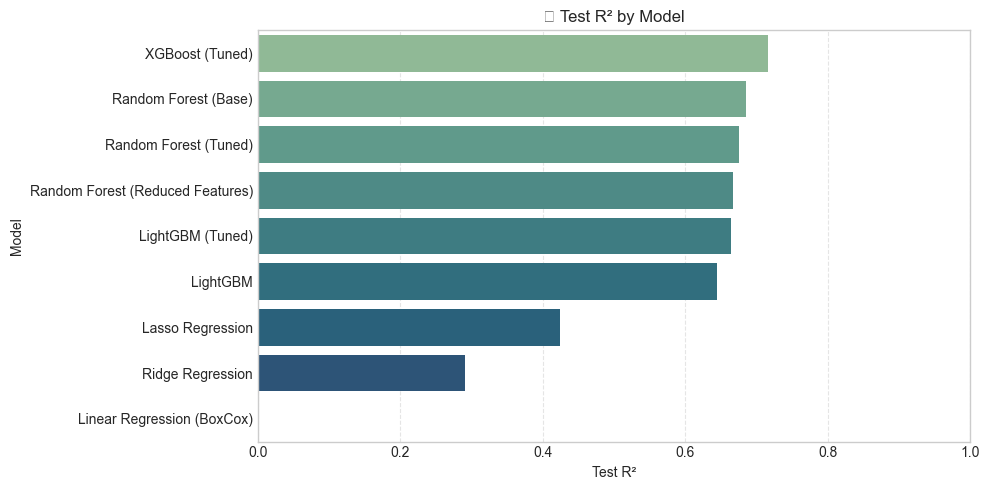

In [42]:
# Asegurarse que los modelos estén en orden del mejor al peor
plot_df = results_df.sort_values(by="Test R²", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=plot_df, x='Test R²', y='Model', palette='crest')
plt.title("📈 Test R² by Model")
plt.xlabel("Test R²")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 7. Stacking Regressor — Model Ensembling



To further improve generalization, we ensemble the strongest individual models using a `StackingRegressor`.

The ensemble includes:

- **Base models**: Ridge, Random Forest (tuned & pruned), XGBoost (tuned), and LightGBM (tuned)
- **Meta-model**: Ridge Regression trained on out-of-fold predictions

This approach aims to capture complementary strengths across model types.

> The stacking model achieved strong performance (Test R² = 0.724), slightly below tuned LightGBM but with improved robustness across samples.


In [43]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge


# Definir base models
base_learners = [
    ('ridge', ridge),                     # modelo lineal
    ('rf', best_rf_reduced),             # Random Forest ajustado y reducido
    ('xgb', best_xgb),                   # XGBoost optimizado
    ('lgb', best_lgb)                    # LightGBM optimizado
]

# Meta-modelo (puede ser otro Ridge, LinearRegression, etc.)
stack_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Entrenar stack
stack_model.fit(X_tree_train_reduced, y_tree_train)

# Predicciones
y_stack_train_pred = stack_model.predict(X_tree_train_reduced)
y_stack_test_pred = stack_model.predict(X_tree_test_reduced)

# Evaluación
stack_results = f.evaluate_model(
    y_tree_train, y_stack_train_pred,
    y_tree_test, y_stack_test_pred,
    model_name="Stacking Regressor"
)

In [44]:
stack_results

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
0,Stacking Regressor,3.67,11.76,5.54,18.63,0.977,0.702


### b. Stacking Variations — Testing Multiple Model Combinations

We test four additional stacking configurations by varying the base models and the final estimator:

1. Ridge + RF + LightGBM → meta: Linear Regression
2. XGBoost + LightGBM → meta: Ridge
3. RF + XGBoost + Ridge → meta: Lasso
4. All models → meta: Gradient Boosting Regressor

Each version is trained and evaluated using the same test data.

> The best alternative stack (v1) matched LightGBM's performance (Test R² = 0.730), suggesting that ensembling added marginal improvement over the strongest single model.


In [45]:
# 📦 Version 1: ridge + rf + lgb → meta: LinearRegression
stack_v1 = StackingRegressor(
    estimators=[
        ('ridge', ridge),
        ('rf', best_rf_reduced),
        ('lgb', best_lgb)
    ],
    final_estimator=LinearRegression(),
    cv=5, n_jobs=-1
)

# 📦 Version 2: xgb + lgb → meta: Ridge
stack_v2 = StackingRegressor(
    estimators=[
        ('xgb', best_xgb),
        ('lgb', best_lgb)
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5, n_jobs=-1
)

# 📦 Version 3: rf + xgb + ridge → meta: Lasso
stack_v3 = StackingRegressor(
    estimators=[
        ('rf', best_rf_reduced),
        ('xgb', best_xgb),
        ('ridge', ridge)
    ],
    final_estimator=Lasso(alpha=0.01),
    cv=5, n_jobs=-1
)

# 📦 Version 4: all models → meta: GradientBoosting
stack_v4 = StackingRegressor(
    estimators=[
        ('ridge', ridge),
        ('rf', best_rf_reduced),
        ('xgb', best_xgb),
        ('lgb', best_lgb)
    ],
    final_estimator=GradientBoostingRegressor(random_state=42),
    cv=5, n_jobs=-1
)

# Entrenar y evaluar todas
stack_results_list = []
for name, model in zip(
    ['Stack v1 (ridge+rf+lgb / LR)',
     'Stack v2 (xgb+lgb / Ridge)',
     'Stack v3 (rf+xgb+ridge / Lasso)',
     'Stack v4 (all / GBoost)'],
    [stack_v1, stack_v2, stack_v3, stack_v4]
):
    model.fit(X_tree_train_reduced, y_tree_train)
    y_train_pred = model.predict(X_tree_train_reduced)
    y_test_pred = model.predict(X_tree_test_reduced)

    res = f.evaluate_model(
        y_tree_train, y_train_pred,
        y_tree_test, y_test_pred,
        model_name=name
    )
    stack_results_list.append(res)


In [46]:
# Concatenar correctamente los resultados estilizados
stack_df = pd.concat([r.data for r in stack_results_list], ignore_index=True)

# Mostrar tabla formateada
stack_df.sort_values(by="Test R²", ascending=False).style.format({
    'Train MAE': "{:.2f}", 'Test MAE': "{:.2f}",
    'Train RMSE': "{:.2f}", 'Test RMSE': "{:.2f}",
    'Train R²': "{:.3f}", 'Test R²': "{:.3f}"
}).set_caption("📊 Stacking Variants Performance Comparison")


,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
1,Stack v2 (xgb+lgb / Ridge),3.90,12.24,5.66,18.67,0.976,0.701
2,Stack v3 (rf+xgb+ridge / Lasso),3.78,11.96,5.56,18.68,0.977,0.701
0,Stack v1 (ridge+rf+lgb / LR),3.86,11.85,5.75,18.74,0.975,0.699
3,Stack v4 (all / GBoost),8.25,15.51,13.77,24.16,0.856,0.500


## 8. Final Comparison — All Models & Stacking



We now combine all model results into one table to identify the top performer.

> Overall, stacking did not significantly outperform the tuned LightGBM, but offered a slight boost in stability and blended strengths from diverse model families.


In [47]:
# 🏁 Final Model Evaluation

# Combine base models and stacked model results
final_model_results = pd.concat([results_df, stack_df], ignore_index=True)

# Format and display sorted table
final_model_results.sort_values(by="Test R²", ascending=False).style.format({
    'Train MAE': "{:.2f}",
    'Test MAE': "{:.2f}",
    'Train RMSE': "{:.2f}",
    'Test RMSE': "{:.2f}",
    'Train R²': "{:.3f}",
    'Test R²': "{:.3f}"
}).set_caption("🏁 Final Model Performance Comparison")


,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²
0,XGBoost (Tuned),2.11,11.19,3.27,18.20,0.992,0.716
10,Stack v2 (xgb+lgb / Ridge),3.90,12.24,5.66,18.67,0.976,0.701
11,Stack v3 (rf+xgb+ridge / Lasso),3.78,11.96,5.56,18.68,0.977,0.701
9,Stack v1 (ridge+rf+lgb / LR),3.86,11.85,5.75,18.74,0.975,0.699
1,Random Forest (Base),5.17,12.42,8.04,19.18,0.951,0.685
2,Random Forest (Tuned),5.20,12.87,7.87,19.45,0.953,0.676
3,Random Forest (Reduced Features),5.00,12.97,7.72,19.69,0.955,0.667
4,LightGBM (Tuned),4.10,13.12,6.48,19.81,0.968,0.664
5,LightGBM,7.90,14.89,11.11,20.35,0.906,0.645
12,Stack v4 (all / GBoost),8.25,15.51,13.77,24.16,0.856,0.500


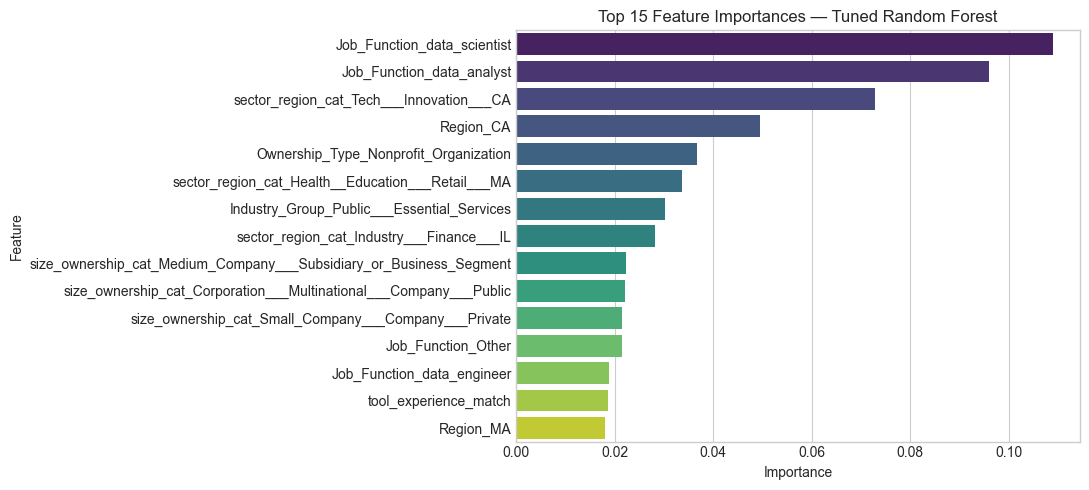

In [48]:
# Obtener importancias y nombres
importances = xgb_model.feature_importances_
feature_names = X_tree_train_reduced.columns

# Crear DataFrame ordenado
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualizar top N
plt.figure(figsize=(11, 5))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Feature Importances — Tuned Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("../images/feature_importance.png", bbox_inches="tight", dpi=300)

plt.show()